In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display


# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

data_dir = pathlib.Path('data/common_violence_words')

commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Commands:', commands)

filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
print('Example file tensor:', filenames[0])

Commands: ['billete' 'cartera' 'celular' 'dame' 'dinero' 'madre' 'no' 'pasame'
 'pendejo' 'perra' 'pinche' 'puta' 'puto' 'telefono' 'todo' 'valieron']
Number of total examples: 400
Number of examples per label: 25
Example file tensor: tf.Tensor(b'data\\common_violence_words\\no\\WhatsApp Ptt 2021-04-11 at 11.36.12 AM (1).wav', shape=(), dtype=string)


In [2]:

train_files = filenames[:320]
val_files = filenames[320: 320+40]
test_files = filenames[-40:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(audio_binary)
  return tf.squeeze(audio, axis=-1)

def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)

  return parts[-2]

def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

AUTOTUNE = tf.data.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)

Training set size 320
Validation set size 40
Test set size 40


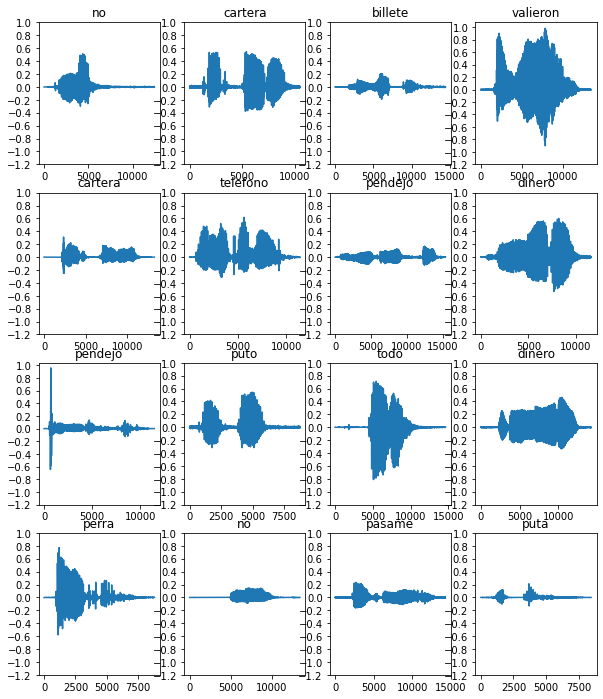

In [3]:
rows = 4
cols = 4
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

Label: dame
Waveform shape: (10727,)
Spectrogram shape: (124, 129)
Audio playback


<ipython-input-4-28f6259fa69e>:35: RuntimeWarning: divide by zero encountered in log
  log_spec = np.log(spectrogram.T)
<ipython-input-4-28f6259fa69e>:40: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(X, Y, log_spec)


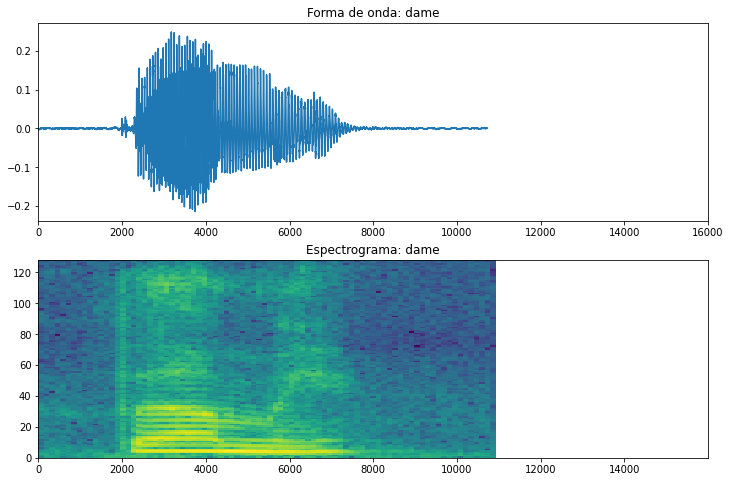

In [4]:
def get_spectrogram(waveform):
  
#   print('Shape: ',waveform.shape[0])
#   if waveform.shape[0] is None or waveform.shape[0] > 16000:
#     equal_length = waveform[:16000]
#     equal_length = tf.cast(equal_length, tf.float32)
#   else:
#     zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.float32)
#     waveform = tf.cast(waveform, tf.float32)
#     equal_length = tf.concat([waveform, zero_padding], 0)
  # Padding for files with less than 16000 samples
  zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.float32)
  waveform = tf.cast(waveform, tf.float32)
  equal_length = tf.concat([waveform, zero_padding], 0)
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)

  spectrogram = tf.abs(spectrogram)

  return spectrogram

for waveform, label in waveform_ds.take(59):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

def plot_spectrogram(spectrogram, ax):
  # Convert to frequencies to log scale and transpose so that the time is
  # represented in the x-axis (columns).
  log_spec = np.log(spectrogram.T)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)


fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Forma de onda: ' + label)
axes[0].set_xlim([0, 16000])
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Espectrograma: ' + label)
plt.show()

<ipython-input-4-28f6259fa69e>:35: RuntimeWarning: divide by zero encountered in log
  log_spec = np.log(spectrogram.T)
<ipython-input-4-28f6259fa69e>:40: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(X, Y, log_spec)


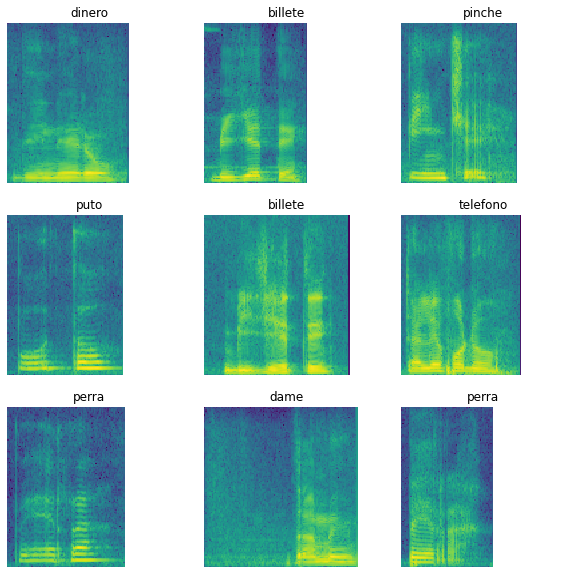

In [5]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  spectrogram = tf.expand_dims(spectrogram, -1)
  label_id = tf.argmax(label == commands)
  return spectrogram, label_id

spectrogram_ds = waveform_ds.map(
    get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)

rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(np.squeeze(spectrogram.numpy()), ax)
  ax.set_title(commands[label_id.numpy()])
  ax.axis('off')

plt.show()

In [6]:
#Building and training model
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      get_spectrogram_and_label_id,  num_parallel_calls=AUTOTUNE)
  return output_ds
#Dividiendo el dataset en training, validation and test
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)
#Definiendo el tamaño de los lotes
batch_size = 16
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)
#Cache y prefetch
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)

norm_layer = preprocessing.Normalization()
norm_layer.adapt(spectrogram_ds.map(lambda x, _: x))

model = models.Sequential([
    layers.Input(shape=input_shape),
    preprocessing.Resizing(32, 32), 
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (124, 129, 1)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing (Resizing)          (None, 32, 32, 1)         0         
_________________________________________________________________
normalization (Normalization (None, 32, 32, 1)         3         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            

In [13]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

EPOCHS = 30
history = model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    #callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/30
20/20 [==============================] - 1s 32ms/step - loss: 0.3282 - accuracy: 0.8862 - val_loss: 1.0307 - val_accuracy: 0.7750
Epoch 2/30
20/20 [==============================] - 1s 26ms/step - loss: 0.3919 - accuracy: 0.9157 - val_loss: 0.8725 - val_accuracy: 0.8000
Epoch 3/30
20/20 [==============================] - 1s 27ms/step - loss: 0.2121 - accuracy: 0.9473 - val_loss: 1.1171 - val_accuracy: 0.8000
Epoch 4/30
20/20 [==============================] - 1s 26ms/step - loss: 0.1417 - accuracy: 0.9663 - val_loss: 1.0786 - val_accuracy: 0.7750
Epoch 5/30
20/20 [==============================] - 1s 26ms/step - loss: 0.2204 - accuracy: 0.9383 - val_loss: 0.7984 - val_accuracy: 0.8000
Epoch 6/30
20/20 [==============================] - 1s 26ms/step - loss: 0.1575 - accuracy: 0.9602 - val_loss: 1.0720 - val_accuracy: 0.8000
Epoch 7/30
20/20 [==============================] - 1s 26ms/step - loss: 0.1437 - accuracy: 0.9681 - val_loss: 0.9839 - val_accuracy: 0.8250
Epoch 8/30
20

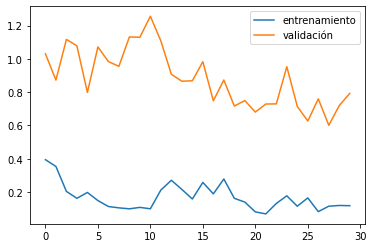

Precisión del modelo: 80%


In [14]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['entrenamiento', 'validación'])
plt.show()

test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
#print(test_audio)
#print(y_pred[0])
#print(y_true[0])
print(f'Precisión del modelo: {test_acc:.0%}')

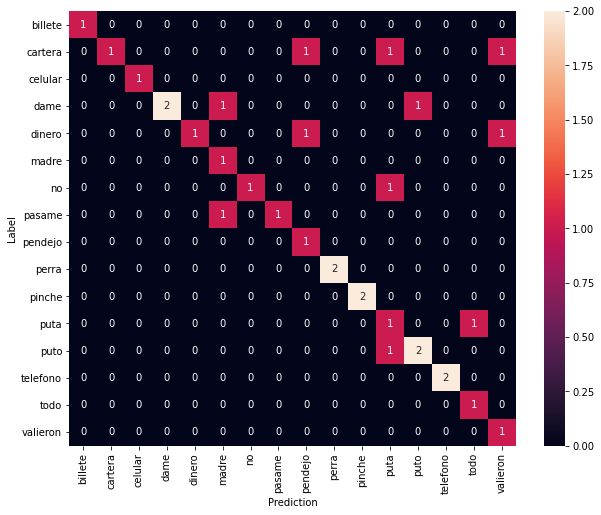

In [9]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

tf.Tensor(
[3.4820636e-11 8.8344071e-10 1.8477869e-11 2.1558200e-11 3.8237777e-09
 1.8870140e-12 2.3611760e-10 1.1932803e-11 3.0407733e-07 1.5547185e-09
 3.7185285e-10 3.1182598e-08 1.9699918e-08 9.9999964e-01 3.1754977e-14
 6.8555639e-10], shape=(16,), dtype=float32)


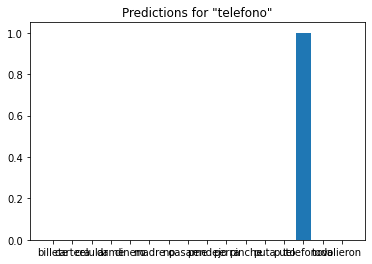

In [10]:
sample_file = data_dir/'telefono/WhatsApp Ptt 2021-04-11 at 11.35.42 AM.wav'

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  print(tf.nn.softmax(prediction[0]))
  plt.bar(commands, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions for "{commands[label[0]]}"')
  plt.show()

In [14]:
from tensorflow import lite
keras_file = "model.h5"
tf.keras.models.save_model(model,keras_file)
converter = lite.TFLiteConverter.from_keras_model(model)
tfmodel = converter.convert()
open("model.tflite","wb").write(tfmodel)

INFO:tensorflow:Assets written to: C:\Users\angel\AppData\Local\Temp\tmp38x0ulzz\assets


6509852